# Spaceship Titanic dataset (Kaggle)

The models implemented here use the following predictors:

- `Age`: The age of the passenger. [`numeric`]
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. [`numeric`]
- `HomePlanet`: The planet the passenger departed from, typically their planet of permanent residence. [`categorical`]
- `CryoSleep`: Indicates whether the passenger was put into suspended animation. Passengers in cryosleep are confined to their cabins. [`categorical`]
- `Destination`: The planet the passenger will be debarking to. [`categorical`]
- `VIP`: Whether the passenger has paid for special VIP service during the voyage. [`categorical`]
- `group_size_bin`: The size of the group the passenger is travellin with (category: "g1", "g2", "g3", "g4more", for 1, 2, 3 or 4-or-more, respectively). [`categorical`]
- `deck`: The deck information from **Cabin** column. [`categorical`]
- `side`: The side information from **Cabin** column. [`categorical`]

\
Label:
- `Transported`: Whether the passenger was transported to another dimension. [`binary`]

\
The best model is a **SVM Classifier** with **polynomial Kernel** (but it is still very similar to the results of the other models).

The performance of the best model on the test set is:
- Accuracy is 0.81.
- When the model claims a passenger was transported to another dimension, it is correct 81.3 % of the time (precision).
- The model detects 82.00 % of the passengers that were transported to another dimension (recall).
- The F1 score is 81.70.


# Load libraries

In [1]:
from pathlib import Path
import sys
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV

np.random.seed(123)

# Python version
print(f"sys: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

sys: 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
numpy: 1.24.2
scipy: 1.10.1
pandas: 1.5.3
matplotlib: 3.7.1


# Load data

In [2]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)
print(f"Shape: {X_y_train.shape}")

Shape: (6954, 14)


In [3]:
print(X_y_train.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [4]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6789 non-null   object 
 2   CryoSleep     6782 non-null   object 
 3   Cabin         6795 non-null   object 
 4   Destination   6805 non-null   object 
 5   Age           6809 non-null   float64
 6   VIP           6800 non-null   object 
 7   RoomService   6801 non-null   float64
 8   FoodCourt     6796 non-null   float64
 9   ShoppingMall  6788 non-null   float64
 10  Spa           6808 non-null   float64
 11  VRDeck        6809 non-null   float64
 12  Name          6786 non-null   object 
 13  Transported   6954 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 713.2+ KB


In [5]:
X_y_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,7527_01,Earth,False,F/1561/P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley,True
1,7083_01,Europa,True,C/259/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Betenar Pirejus,True
2,2755_01,Europa,True,B/85/P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Beneba Glousspidy,True
3,4127_01,Europa,NaN,B/130/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Dsch Ainserfle,True
4,7972_02,Europa,False,B/260/P,TRAPPIST-1e,35.0,False,NaN,246.0,25.0,42.0,3730.0,Atinon Cattyried,False


In [6]:
print(f"shape X_y_train: {X_y_train.shape}")

shape X_y_train: (6954, 14)


In [7]:
# NOTE: "drop()" create a copy of the data original dataset
X_train = X_y_train.drop(["Transported"], axis=1)
y_train = X_y_train.loc[:, "Transported"].copy()

print(f"shape X_train: {X_train.shape}")
print(f"shape y_train: {y_train.shape}")

shape X_train: (6954, 13)
shape y_train: (6954,)


# Define functions

In [8]:
def add_metrics(dictionary, y, y_pred, mod_name):
    # dictionary: a dictionary to which the metrics are added

    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    dictionary[mod_name] = {
        "accuracy": np.round(acc, 3),
        "confusion_matrix": cm,
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "f1_score": np.round(f1, 3)
    }

    return dictionary


def print_metrics(m):
    print(f"Accuracy is {m['accuracy']:.2f}.")
    print(f"When the model claims a passenger was transported to another dimension, it is correct {m['precision']*100} % of the time (precision).")
    print(f"The model detects {m['recall']*100:.2f} % of the passengers that were transported to another dimension (recall).")
    print(f"The F1 score is {m['f1_score']*100:.2f}.")


def display_cm(cm):
    # cm: a confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


def compare_models(models):
    mods_table = pd.DataFrame.from_dict(models)
    return mods_table.loc[["accuracy", "precision", "recall", "f1_score"],:]

# Define pipelines

In [9]:
# Define columns to convert
c_cat = ["HomePlanet", "Cabin", "Destination"]
c_str = ["PassengerId", "Name"]
# c_bool = ["CryoSleep", "VIP"]

In [10]:
# Function to convert data type & add column
def convert_df(df_in: pd.DataFrame,
               col_cat: list[str],
               col_str: list[str],
               # col_bool: list[str]
 ) -> pd.DataFrame:
    """Converts the specified columns to categorical, string or bool types."""

    df_out = df_in.copy()

    for column in col_cat:
        df_out[column] = df_out[column].astype("category")
    
    for column in col_str:
        df_out[column] = df_out[column].astype("string")

    # NOTE: EXCLUDED because "SimpleImputer" does not support data with dtype bool
    # for column in col_bool:
    #     df_out[column] = df_out[column].astype("bool")

    return df_out

## CombinedAttributesAdder

Define a class that transforms and select various features.

In [11]:
# TransformerMixin: add method ".fit_transform()"
# BaseEstimator: add methods ".get_params()" and ".set_params()"
# We need 3 methods:
# 1) .fit()
# 2) .transform()
# 3) .fit_transform() (provided by "TransformerMixin")
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # avoid '*args' or "**kargs" in "__init__"
    def __init__(self):
        pass

    # fit is needed later for the pipilene
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert column type
        X = convert_df(
            df_in=X,
            col_cat=c_cat,
            col_str=c_str,
            #col_bool=c_bool,
        )

        # Add "group" and "group_n"
        X[["group", "group_n"]] = X.PassengerId.str.split("_", expand=True)

        # Add "group_size" (a column with the size of the group)
        count_group_size = (
             X
             .value_counts(["group"], sort=False)
             .rename("group_size")
             .reset_index()
        )
        X = pd.merge(X, count_group_size, how="left", on="group")

        # Add "group_size_bin"
        X.loc[:, "group_size_bin"] = np.nan
        X.loc[X.group_size == 1, "group_size_bin"] = "g1"
        X.loc[X.group_size == 2, "group_size_bin"] = "g2"
        X.loc[X.group_size == 3, "group_size_bin"] = "g3"
        X.loc[X.group_size >= 4, "group_size_bin"] = "g4more"
        X["group_size_bin"] = X["group_size_bin"].astype("category")

        # Add "deck", "num" and "side"
        X[["deck", "num", "side"]] = X.Cabin.str.split("/", expand=True)
        X["deck"] = X["deck"].astype("category")
        X["num"] = X["num"].astype("string")
        X["side"] = X["side"].astype("category")
        
        # Drop unused columns
        cols_to_drop = ['PassengerId', 'Cabin', 'Name', 'group',
                        'group_n', 'group_size', 'num']
        X.drop(columns=cols_to_drop, inplace=True)

        return X

## num_pipeline

It preprocesses the numerical attributes with `SimpleImputer()` and `StandardScaler()`.

In [12]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
num_pipeline = Pipeline([
    # replace NA with mean
    ('imputer', SimpleImputer(strategy='mean')),
    # standardize the variables: z = (x - mean) / SD
    ('std_scaler', StandardScaler())])

## cat_pipeline

It preprocesses the categorical attributed with `SimpleImputer()` and `OneHotEncoder()`.

In [13]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
cat_pipeline = Pipeline([
    # replace NA with mode
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # apply "OneHotEncoder()"
    ('one_hot', OneHotEncoder())])

## Combine pipelines

In [14]:
list_num_attribs = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
list_cat_attribs = ["HomePlanet", "CryoSleep", "Destination", "VIP", "group_size_bin", "deck", "side"]

In [15]:
# ColumnTransformer requires tuples with:
# - a name
# - a transformer
# - a list of names (or indices) of columns to which the transformer is applied

cols_transformer = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, list_num_attribs),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, list_cat_attribs)])

In [16]:
full_pipeline = Pipeline([
    # transform/add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform numerical and categorical attributes
    ("cols_transformer", cols_transformer)])

In [17]:
# print(full_pipeline.get_params().keys())
# print(full_pipeline.get_params().items())
print(full_pipeline.get_params())


{'memory': None, 'steps': [('attribs_adder', CombinedAttributesAdder()), ('cols_transformer', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot', OneHotEncoder())]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'group_size_bin', 'deck', 'side'])]))], 'verbose': False, 'attribs_adder': CombinedAttributesAdder(), 'cols_transformer': C

In [18]:
for i in full_pipeline.get_params().keys():
    print(i)

memory
steps
verbose
attribs_adder
cols_transformer
cols_transformer__n_jobs
cols_transformer__remainder
cols_transformer__sparse_threshold
cols_transformer__transformer_weights
cols_transformer__transformers
cols_transformer__verbose
cols_transformer__verbose_feature_names_out
cols_transformer__num
cols_transformer__cat
cols_transformer__num__memory
cols_transformer__num__steps
cols_transformer__num__verbose
cols_transformer__num__imputer
cols_transformer__num__std_scaler
cols_transformer__num__imputer__add_indicator
cols_transformer__num__imputer__copy
cols_transformer__num__imputer__fill_value
cols_transformer__num__imputer__keep_empty_features
cols_transformer__num__imputer__missing_values
cols_transformer__num__imputer__strategy
cols_transformer__num__imputer__verbose
cols_transformer__num__std_scaler__copy
cols_transformer__num__std_scaler__with_mean
cols_transformer__num__std_scaler__with_std
cols_transformer__cat__memory
cols_transformer__cat__steps
cols_transformer__cat__verbo

# Decision Tree

This model overfit the train set

In [19]:
clf_tree = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Decision Tree (defaul parameters)
    ("tree", DecisionTreeClassifier(random_state=584))])

In [20]:
clf_tree.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder())]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side'])]))])),
                ('tree', DecisionTreeClassifier(random_state=584))])

In [21]:
y_pred_tree = clf_tree.predict(X_train)

In [22]:
model_score_tree = dict()
model_score_tree = add_metrics(model_score_tree, y_train, y_pred_tree, "tree")

In [23]:
print_metrics(model_score_tree["tree"])

Accuracy is 0.97.
When the model claims a passenger was transported to another dimension, it is correct 97.5 % of the time (precision).
The model detects 96.40 % of the passengers that were transported to another dimension (recall).
The F1 score is 96.90.


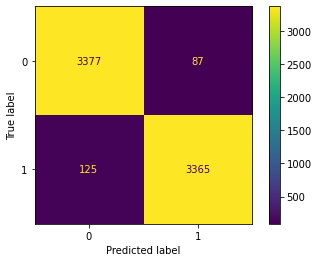

In [24]:
display_cm(model_score_tree["tree"]["confusion_matrix"])

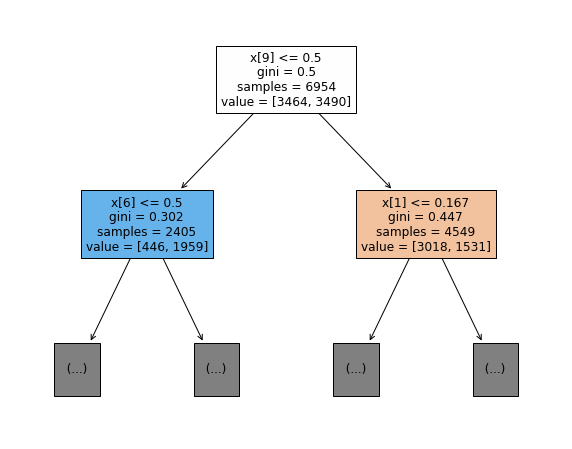

In [25]:
# Show graph
plt.figure(figsize=(10,8))
plot_tree(clf_tree["tree"], max_depth=1, filled=True)
plt.show()

# Grid Search

In [26]:
cls_tree_gs = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Decision Tree (defaul parameters)
    ("tree", DecisionTreeClassifier(random_state=584))])

In [27]:
list(cls_tree_gs["tree"].get_params().keys())

['ccp_alpha',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'random_state',
 'splitter']

In [28]:
param_grid = {
    "tree__max_depth": [3, 5, 6, 7, 8, 9, 10],
    "tree__max_features": [None, "sqrt", "log2"],
    "tree__min_samples_leaf": [1, 5, 10, 15, 20]}

clf_gs = GridSearchCV(
    estimator=cls_tree_gs,
    param_grid=param_grid,
    cv=5, # train across 5 folds
    scoring='accuracy',
    verbose=1)

In [29]:
clf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        Pipeline(steps=[('attribs_adder',
                                                         CombinedAttributesAdder()),
                                                        ('cols_transformer',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('std_scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['Age',
                                                                                           'RoomService',
                                                                                           'FoodCourt',
                                                                                           'ShoppingMall',
                                                                                           'Spa',
                                                                                           'VRDeck']),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('impu...
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('one_hot',
                                                                                                           OneHotEncoder())]),
                                                                                          ['HomePlanet',
                                                                                           'CryoSleep',
                                                                                           'Destination',
                                                                                           'VIP',
                                                                                           'group_size_bin',
                                                                                           'deck',
                                                                                           'side'])]))])),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=584))]),
             param_grid={'tree__max_depth': [3, 5, 6, 7, 8, 9, 10],
                         'tree__max_features': [None, 'sqrt', 'log2'],
                         'tree__min_samples_leaf': [1, 5, 10, 15, 20]},
             scoring='accuracy', verbose=1)

In [30]:
# clf_gs.best_estimator_
print(f"Best parameters:\n{clf_gs.best_params_}")
print(f"\nBest score: {clf_gs.best_score_:.3f}")
print(f"\nMean accuracy on the full train set: {clf_gs.score(X_train, y_train):.3f}")

Best parameters:
{'tree__max_depth': 9, 'tree__max_features': None, 'tree__min_samples_leaf': 15}

Best score: 0.780

Mean accuracy on the full train set: 0.807
